### Import Required Packages and Set Options

#### Import Base Libraries

In [296]:
import os
import sys
import git

import numpy as np
import numba as nb
import pandas as pd
import multiprocessing as mp

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from functools import partial

In [297]:
sns.set_style('whitegrid')
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
# plt.rcParams

#### Put the Main Package Library on the PYTHONPATH

In [203]:
git_repo = git.Repo('.', search_parent_directories=True)
git_root = git_repo.git.rev_parse('--show-toplevel')

sys.path[0] = git_root
sys.path[0]

'/Users/ericlundquist/Repos/rankfm'

#### Dynamically Re-Load all Package Modules on Execution

In [204]:
%load_ext autoreload
%autoreload 2

from rankfm.rankfm import RankFM
from rankfm.evaluation import hit_rate, reciprocal_rank, discounted_cumulative_gain, precision, recall, diversity

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Set File Path Constants

In [205]:
REPO_ROOT = os.path.split(srcdir)[0]
DATA_ROOT = os.path.join(REPO_ROOT, "data/ml-100k")
print("\n".join([REPO_ROOT, DATA_ROOT]))

/Users/ericlundquist/Repos/rankfm
/Users/ericlundquist/Repos/rankfm/data/ml-100k


### Prepare Example Data

#### Load Users Data

In [206]:
users_df = pd.read_csv(os.path.join(DATA_ROOT, "users.csv"))
users_df['agegroup'] = pd.cut(users_df['age'], [0, 30, 45, 100], right=False, labels=False)
users_df = users_df.drop(['age', 'zip_code'], axis=1)
users_df = pd.get_dummies(users_df, prefix_sep='__', columns=['agegroup', 'gender', 'occupation'])
users_df.mean()

user_id                      472.000000
agegroup__0                    0.433722
agegroup__1                    0.348887
agegroup__2                    0.217391
gender__F                      0.289502
gender__M                      0.710498
occupation__administrator      0.083775
occupation__artist             0.029692
occupation__doctor             0.007423
occupation__educator           0.100742
occupation__engineer           0.071050
occupation__entertainment      0.019088
occupation__executive          0.033934
occupation__healthcare         0.016967
occupation__homemaker          0.007423
occupation__lawyer             0.012725
occupation__librarian          0.054083
occupation__marketing          0.027572
occupation__none               0.009544
occupation__other              0.111347
occupation__programmer         0.069989
occupation__retired            0.014846
occupation__salesman           0.012725
occupation__scientist          0.032874
occupation__student            0.207847


#### Load Items Data

In [207]:
items_df = pd.read_csv(os.path.join(DATA_ROOT, "items.csv"))
item_names = items_df[['item_id', 'item_name']]
item_names.head()

,item_id,item_name
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [208]:
items_df = items_df.drop(['item_name', 'release_date'], axis=1)
items_df.columns = ['item_id'] + ["genre__{}".format(col) for col in items_df.columns[1:]]
items_df.mean()

item_id               841.500000
genre__action           0.149227
genre__adventure        0.080262
genre__animation        0.024970
genre__childrens        0.072533
genre__comedy           0.300238
genre__crime            0.064804
genre__documentary      0.029727
genre__drama            0.431034
genre__fantasy          0.013080
genre__film_noir        0.014269
genre__horror           0.054697
genre__musical          0.033294
genre__mystery          0.036266
genre__romance          0.146849
genre__scifi            0.060048
genre__thriller         0.149227
genre__war              0.042212
genre__western          0.016052
dtype: float64

#### Load Ratings Data

In [209]:
ratings_explicit = pd.read_csv(os.path.join(DATA_ROOT, "ratings.csv"))
ratings_explicit['timestamp'] = pd.to_datetime(ratings_explicit['unix_timestamp'], origin='unix', unit='s')
ratings_explicit['positive_feedback'] = ratings_explicit.groupby('user_id')['rating'].transform(lambda c: np.where(c > c.mean(), 1, 0))
ratings_explicit = ratings_explicit.drop('unix_timestamp', axis=1)
ratings_explicit.mean()

user_id              462.48475
item_id              425.53013
rating                 3.52986
positive_feedback      0.54194
dtype: float64

In [210]:
ratings_explicit.head()

,user_id,item_id,rating,timestamp,positive_feedback
0,196,242,3,1997-12-04 15:55:49,0
1,186,302,3,1998-04-04 19:22:22,0
2,22,377,1,1997-11-07 07:18:36,0
3,244,51,2,1997-11-27 05:02:03,0
4,166,346,1,1998-02-02 05:33:16,0


#### Generate Implicit Feedback Ratings Data

In [211]:
ratings_implicit = ratings_explicit[ratings_explicit.positive_feedback == 1].reset_index(drop=True)
ratings_implicit.head()

,user_id,item_id,rating,timestamp,positive_feedback
0,253,465,5,1998-04-03 18:34:27,1
1,286,1014,5,1997-11-17 15:38:45,1
2,200,222,5,1997-10-05 09:05:40,1
3,224,29,3,1998-02-21 23:40:57,1
4,122,387,5,1997-11-11 17:47:39,1


#### Print Final Matrix Shapes

In [212]:
print(ratings_explicit.user_id.nunique(), ratings_explicit.item_id.nunique())
print(ratings_implicit.user_id.nunique(), ratings_implicit.item_id.nunique())

print(ratings_explicit.shape)
print(ratings_implicit.shape)

943 1682
943 1483
(100000, 5)
(54194, 5)


#### Create (Training, Validation) Interactions for Evaluation

In [213]:
print(ratings_implicit.shape)
ratings_implicit.head()

(54194, 5)


,user_id,item_id,rating,timestamp,positive_feedback
0,253,465,5,1998-04-03 18:34:27,1
1,286,1014,5,1997-11-17 15:38:45,1
2,200,222,5,1997-10-05 09:05:40,1
3,224,29,3,1998-02-21 23:40:57,1
4,122,387,5,1997-11-11 17:47:39,1


In [214]:
# ratings_implicit['user_id'] = ratings_implicit['user_id'].astype('str')
# ratings_implicit['item_id'] = ratings_implicit['item_id'].astype('str')
# ratings_implicit.info()

In [215]:
test_pct = 0.25
drop_users = (2, 4)

train_mask = (ratings_implicit.index / ratings_implicit.shape[0]) <  (1 - test_pct)
valid_mask = (ratings_implicit.index / ratings_implicit.shape[0]) >= (1 - test_pct)

interactions_total = ratings_implicit[['user_id', 'item_id']]
interactions_train = ratings_implicit[train_mask][['user_id', 'item_id']]
interactions_valid = ratings_implicit[valid_mask][['user_id', 'item_id']]

# drop some users from the training data to test cold-start functionality
interactions_train = interactions_train[~interactions_train.user_id.isin(drop_users)]

train_users = np.sort(interactions_train.user_id.unique())
valid_users = np.sort(interactions_valid.user_id.unique())
cold_start_users = set(valid_users) - set(train_users)

print("total shape: {}".format(interactions_total.shape))
print("train shape: {}".format(interactions_train.shape))
print("valid shape: {}".format(interactions_valid.shape))
print("train users: {}".format(len(train_users)))
print("valid users: {}".format(len(valid_users)))
print("cold-start users: {}".format(cold_start_users))

total shape: (54194, 2)
train shape: (40598, 2)
valid shape: (13548, 2)
train users: 941
valid users: 905
cold-start users: {2, 4}


In [216]:
iteraction_users = interactions_train.user_id.unique()
iteraction_items = interactions_train.item_id.unique()

#### Create User/Item Features Data for Testing

In [217]:
user_features = users_df[users_df.user_id.isin(iteraction_users)]
print(user_features.shape, users_df.shape)
user_features.head()

(941, 27) (943, 27)


,user_id,agegroup__0,agegroup__1,agegroup__2,gender__F,gender__M,occupation__administrator,occupation__artist,occupation__doctor,occupation__educator,...,occupation__marketing,occupation__none,occupation__other,occupation__programmer,occupation__retired,occupation__salesman,occupation__scientist,occupation__student,occupation__technician,occupation__writer
0,1,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,3,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,5,0,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
5,6,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [218]:
item_features = items_df[items_df.item_id.isin(iteraction_items)]
print(item_features.shape, items_df.shape)
item_features.head()

(1421, 19) (1682, 19)


,item_id,genre__action,genre__adventure,genre__animation,genre__childrens,genre__comedy,genre__crime,genre__documentary,genre__drama,genre__fantasy,genre__film_noir,genre__horror,genre__musical,genre__mystery,genre__romance,genre__scifi,genre__thriller,genre__war,genre__western
0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


### Test Out Core Package Functionality

In [219]:
interactions_train.shape, user_features.shape, item_features.shape

((40598, 2), (941, 27), (1421, 19))

In [220]:
interactions_train.dtypes

user_id    int64
item_id    int64
dtype: object

#### Initialize the Model

In [221]:
model = RankFM(factors=10, learning_rate=0.1, regularization=0.01, sigma=0.1)
model

#### Initialize and Inspect Internal Data

In [222]:
%%time
model._init_all(interactions_train, user_features, item_features)

CPU times: user 132 ms, sys: 8.64 ms, total: 141 ms
Wall time: 154 ms


In [223]:
print(len(model.user_id), len(model.user_idx))
print(len(model.item_id), len(model.item_idx))

941 941
1421 1421


In [224]:
print(model.interactions.shape)
print(model.x_uf.shape)
print(model.x_if.shape)

(40598, 2)
(941, 26)
(1421, 18)


In [225]:
print("item weights: {}".format(model.w_i.shape))
print("item feature weights: {}".format(model.w_if.shape))
print("user factors: {}".format(model.v_u.shape))
print("item factors: {}".format(model.v_i.shape))
print("user feature factors: {}".format(model.v_uf.shape))
print("item feature factors: {}".format(model.v_if.shape))

item weights: (1421,)
item feature weights: (18,)
user factors: (941, 10)
item factors: (1421, 10)
user feature factors: (26, 10)
item feature factors: (18, 10)


In [226]:
model.interactions.dtype

dtype('int32')

In [227]:
model.user_items_nb[10]

array([  3,  11,  12,  13,  21,  22,  31,  32,  41,  47,  48,  49,  55,
        57,  58,  60,  61,  63,  68,  70,  71,  86,  87,  88,  94,  95,
        96,  97,  98,  99, 106, 108, 115, 118, 121, 124, 134, 141, 147,
       149, 150, 151, 157, 158, 164, 165, 167, 169, 171, 174, 175, 177,
       178, 180, 183, 187, 190, 191, 193, 194, 196, 199, 201, 205, 208,
       209, 212, 220, 221, 223, 224, 225, 226, 230, 231, 234, 236, 255,
       259, 260, 261, 262, 265, 267, 269, 273, 276, 287, 289, 299, 300,
       302, 307, 310, 311, 312, 313, 315, 338, 341, 342, 343, 349, 356,
       396, 398, 408, 414, 417, 420, 421, 423, 426, 428, 432, 433, 438,
       451, 452, 456, 461, 462, 463, 466, 467, 471, 472, 473, 480, 481,
       482, 483, 486, 487, 490, 491, 495, 498, 499, 500, 503, 505, 506,
       507, 508, 509, 512, 513, 516, 518, 519, 538, 554, 558, 573, 576,
       587, 588, 589, 590, 592, 598, 599, 600, 601, 607, 610, 632, 637,
       638, 640, 641, 642, 643, 647, 648, 649, 661, 664, 669, 67

In [228]:
uf_checker = pd.DataFrame(model.x_uf, columns=user_features.columns[1:])
uf_checker.head()

,agegroup__0,agegroup__1,agegroup__2,gender__F,gender__M,occupation__administrator,occupation__artist,occupation__doctor,occupation__educator,occupation__engineer,...,occupation__marketing,occupation__none,occupation__other,occupation__programmer,occupation__retired,occupation__salesman,occupation__scientist,occupation__student,occupation__technician,occupation__writer
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [229]:
user_features[user_features.user_id.isin(pd.Series([0,1,2,3,4]).map(model.index_to_user))]

,user_id,agegroup__0,agegroup__1,agegroup__2,gender__F,gender__M,occupation__administrator,occupation__artist,occupation__doctor,occupation__educator,...,occupation__marketing,occupation__none,occupation__other,occupation__programmer,occupation__retired,occupation__salesman,occupation__scientist,occupation__student,occupation__technician,occupation__writer
0,1,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,3,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,5,0,1,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
5,6,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,0,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [230]:
if_checker = pd.DataFrame(model.x_if, columns=item_features.columns[1:])
if_checker.head()

,genre__action,genre__adventure,genre__animation,genre__childrens,genre__comedy,genre__crime,genre__documentary,genre__drama,genre__fantasy,genre__film_noir,genre__horror,genre__musical,genre__mystery,genre__romance,genre__scifi,genre__thriller,genre__war,genre__western
0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [231]:
item_features[item_features.item_id.isin(pd.Series([0,1,2,3,4]).map(model.index_to_item))]

,item_id,genre__action,genre__adventure,genre__animation,genre__childrens,genre__comedy,genre__crime,genre__documentary,genre__drama,genre__fantasy,genre__film_noir,genre__horror,genre__musical,genre__mystery,genre__romance,genre__scifi,genre__thriller,genre__war,genre__western
0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


#### Fit the Model on the Training Data and Profile Computational Performance

In [349]:
interactions_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40598 entries, 0 to 40645
Data columns (total 2 columns):
user_id    40598 non-null int64
item_id    40598 non-null int64
dtypes: int64(2)
memory usage: 951.5 KB


In [350]:
model = RankFM(factors=10, regularization=0.01, sigma=0.1, learning_rate=0.10, learning_schedule='constant', learning_exponent=0.25)
model

In [351]:
%%time

# model.fit(interactions_train, item_features=item_features, epochs=50, verbose=True)
model.fit(interactions_train, epochs=100, verbose=True)


training epoch: 0
log likelihood: -19184.07

training epoch: 1
log likelihood: -15771.67

training epoch: 2
log likelihood: -14842.51

training epoch: 3
log likelihood: -14300.41

training epoch: 4
log likelihood: -13259.46

training epoch: 5
log likelihood: -12067.38

training epoch: 6
log likelihood: -11190.87

training epoch: 7
log likelihood: -10529.41

training epoch: 8
log likelihood: -10167.1

training epoch: 9
log likelihood: -9717.98

training epoch: 10
log likelihood: -9517.92

training epoch: 11
log likelihood: -9223.06

training epoch: 12
log likelihood: -8847.11

training epoch: 13
log likelihood: -8807.58

training epoch: 14
log likelihood: -8671.17

training epoch: 15
log likelihood: -8556.13

training epoch: 16
log likelihood: -8420.98

training epoch: 17
log likelihood: -8288.11

training epoch: 18
log likelihood: -8303.99

training epoch: 19
log likelihood: -8248.14

training epoch: 20
log likelihood: -8222.92

training epoch: 21
log likelihood: -8168.92

training ep

In [334]:
# model.fit_partial(interactions_train, epochs=5, verbose=True)

#### Generate Model Scores

In [352]:
interactions_total.shape

(54194, 2)

In [353]:
%%time
scores = model.predict(interactions_total, cold_start='nan') 

CPU times: user 70.9 ms, sys: 3.91 ms, total: 74.8 ms
Wall time: 74.5 ms


#### Generate TopN Recommendations

In [354]:
all_users = pd.Series(interactions_total.user_id.unique())
print(all_users.shape)
all_users.head(10)

(943,)


0    253
1    286
2    200
3    224
4    122
5    291
6    119
7    167
8    299
9    308
dtype: int64

In [355]:
%%time
top_recs = model.recommend_for_users(all_users, n_items=10, filter_previous=False, cold_start='nan')

CPU times: user 518 ms, sys: 9.87 ms, total: 528 ms
Wall time: 135 ms


In [356]:
top_recs.head()

,0,1,2,3,4,5,6,7,8,9
253,50.0,69.0,204.0,28.0,56.0,181.0,22.0,318.0,172.0,210.0
286,83.0,272.0,248.0,421.0,588.0,258.0,268.0,710.0,173.0,1119.0
200,22.0,50.0,56.0,69.0,121.0,181.0,174.0,172.0,28.0,222.0
224,332.0,15.0,22.0,51.0,54.0,742.0,729.0,1119.0,280.0,69.0
122,708.0,213.0,655.0,52.0,200.0,64.0,185.0,527.0,238.0,157.0


### Evaluate Model Performance on the Validation Data

#### Specify Number of Recommended Items

In [357]:
k = 10

#### Generate Pure-Popularity Baselines

In [358]:
most_popular = interactions_train.groupby('item_id')['user_id'].count().sort_values(ascending=False)[:k]
most_popular

item_id
50     357
100    291
181    277
258    260
98     249
174    246
127    245
1      225
56     223
313    221
Name: user_id, dtype: int64

In [359]:
test_user_items = interactions_valid.groupby('user_id')['item_id'].apply(set).to_dict()
test_recommends = model.recommend_for_users(list(test_user_items.keys()), cold_start='drop')
test_user_items = {key: val for key, val in test_user_items.items() if key in test_recommends.index}

base_pre = round(np.mean([len(set(most_popular.index) & set(val)) / len(set(most_popular.index)) for key, val in test_user_items.items()]), 3)
base_rec = round(np.mean([len(set(most_popular.index) & set(val)) / len(set(val))                for key, val in test_user_items.items()]), 3)

print("number of test users: {}".format(len(test_user_items)))
print("baseline precision: {}".format(base_pre))
print("baseline recall: {}".format(base_rec))

number of test users: 903
baseline precision: 0.098
baseline recall: 0.088


#### Generate Model Performance Validation Metriccs

In [360]:
%%time
model_hit_rate = hit_rate(model, interactions_valid, k=k)

CPU times: user 1 s, sys: 12.5 ms, total: 1.01 s
Wall time: 319 ms


In [361]:
%%time 
model_reciprocal_rank = reciprocal_rank(model, interactions_valid, k=k)

CPU times: user 1.72 s, sys: 15.5 ms, total: 1.74 s
Wall time: 681 ms


In [362]:
%%time 
model_dcg = discounted_cumulative_gain(model, interactions_valid, k=k)

CPU times: user 1.54 s, sys: 13.3 ms, total: 1.56 s
Wall time: 690 ms


In [363]:
%%time
model_precision = precision(model, interactions_valid, k=k)

CPU times: user 1.28 s, sys: 8.73 ms, total: 1.28 s
Wall time: 386 ms


In [364]:
%%time
model_recall = recall(model, interactions_valid, k=k)

CPU times: user 971 ms, sys: 8.25 ms, total: 979 ms
Wall time: 315 ms


In [365]:
print("hit_rate: {}".format(round(model_hit_rate, 3)))
print("reciprocal_rank: {}".format(round(model_reciprocal_rank, 3)))
print("dcg: {}".format(round(model_dcg, 3)))
print("precision: {}".format(round(model_precision, 3)))
print("recall: {}".format(round(model_recall, 3)))

hit_rate: 0.633
reciprocal_rank: 0.287
dcg: 0.6
precision: 0.127
recall: 0.144


#### Generate Item Diversity DataFrame

In [327]:
model_diversity = diversity(model, interactions_valid, k=k)
model_diversity.head(10)

,item_id,cnt_users,pct_users
0,50,456,0.504983
1,174,321,0.355482
2,258,253,0.280177
3,181,240,0.265781
4,127,229,0.253599
5,286,213,0.235880
6,98,207,0.229236
7,300,201,0.222591
8,100,195,0.215947
9,204,192,0.212625


In [328]:
top_item_names = item_names[item_names.item_id.isin(model_diversity.item_id[:10])].set_index('item_id').loc[model_diversity.item_id[:10]].reset_index()
top_item_names = pd.merge(top_item_names, model_diversity, on='item_id', how='inner')
top_item_names

,item_id,item_name,cnt_users,pct_users
0,50,Star Wars (1977),456,0.504983
1,174,Raiders of the Lost Ark (1981),321,0.355482
2,258,Contact (1997),253,0.280177
3,181,Return of the Jedi (1983),240,0.265781
4,127,"Godfather, The (1972)",229,0.253599
5,286,"English Patient, The (1996)",213,0.235880
6,98,"Silence of the Lambs, The (1991)",207,0.229236
7,300,Air Force One (1997),201,0.222591
8,100,Fargo (1996),195,0.215947
9,204,Back to the Future (1985),192,0.212625


In [329]:
coverage = np.mean(model_diversity['cnt_users'] > 0)
round(coverage, 3)

0.256

In [330]:
nonzero = model_diversity[model_diversity.cnt_users > 0]
entropy = -np.sum(nonzero['pct_users'] * np.log2(nonzero['pct_users']))
round(entropy, 2)

35.98

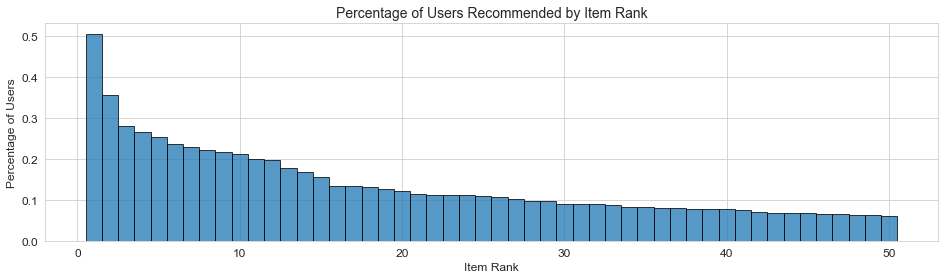

In [331]:
fig, axes = plt.subplots(1, 1, figsize=[16, 4])
N = 50

topN = model_diversity.iloc[:N, :]
axes.bar(topN.index.values + 1, topN.pct_users, width=1, edgecolor='black', alpha=0.75)
axes.set(xlabel='Item Rank', ylabel='Percentage of Users', title='Percentage of Users Recommended by Item Rank')
plt.show()

### QA the Predict/Recommend/Similarity Methods

#### Generate Model Scores for Test User/Items

In [77]:
mask = (interactions_valid.user_id.isin(interactions_train.user_id)) & (interactions_valid.item_id.isin(interactions_train.item_id))
print(interactions_valid.shape)
print(interactions_valid[mask].shape)

(13548, 2)
(13469, 2)


In [78]:
scores_miss = model.predict(interactions_valid, cold_start='nan')
scores_drop = model.predict(interactions_valid, cold_start='drop')

print(scores_miss.shape)
print(scores_drop.shape)

(13548,)
(13469,)


#### Spot-Check Some User Recommendations

In [79]:
len(train_users), len(valid_users), cold_start_users

(941, 905, {2, 4})

In [80]:
recommendations = model.recommend_for_users(valid_users, n_items=10, filter_previous=True, cold_start='nan')
print(recommendations.shape)
recommendations.head(10)

(905, 10)


,0,1,2,3,4,5,6,7,8,9
1,200.0,172.0,11.0,273.0,603.0,204.0,357.0,655.0,218.0,318.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,313.0,300.0,333.0,301.0,258.0,690.0,245.0,748.0,272.0,315.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,96.0,174.0,210.0,202.0,195.0,72.0,22.0,200.0,82.0,181.0
6,496.0,654.0,603.0,659.0,172.0,48.0,182.0,647.0,190.0,606.0
7,202.0,143.0,176.0,318.0,173.0,50.0,1.0,211.0,12.0,95.0
8,96.0,1.0,168.0,98.0,186.0,202.0,234.0,204.0,173.0,12.0
9,127.0,258.0,313.0,100.0,1.0,56.0,268.0,98.0,181.0,288.0
10,318.0,514.0,511.0,427.0,213.0,238.0,515.0,98.0,194.0,64.0


In [81]:
user_id = 5
user_recs = recommendations.loc[user_id]
user_item_names = item_names[item_names.item_id.isin(user_recs)].set_index('item_id').loc[user_recs]
user_item_names

,item_name
item_id,
96.0,Terminator 2: Judgment Day (1991)
174.0,Raiders of the Lost Ark (1981)
210.0,Indiana Jones and the Last Crusade (1989)
202.0,Groundhog Day (1993)
195.0,"Terminator, The (1984)"
72.0,"Mask, The (1994)"
22.0,Braveheart (1995)
200.0,"Shining, The (1980)"
82.0,Jurassic Park (1993)


#### Look at Similar Movies for a Few Recommended Movies

In [82]:
most_similar_items = model.similar_items(184.0)
most_similar_names = item_names.set_index('item_id').loc[most_similar_items]
most_similar_names

,item_name
item_id,
227,Star Trek VI: The Undiscovered Country (1991)
219,"Nightmare on Elm Street, A (1984)"
201,Evil Dead II (1987)
128,Supercop (1992)
200,"Shining, The (1980)"
68,"Crow, The (1994)"
17,From Dusk Till Dawn (1996)
550,Die Hard: With a Vengeance (1995)
92,True Romance (1993)


### Look at the Movies with the Highest/Lowest Model Weights

In [83]:
item_weights = pd.DataFrame({'item_idx': np.arange(len(model.w_i)), 'w_item': model.w_i})
item_weights['item_id'] = item_weights['item_idx'].map(model.index_to_item)
item_weights = pd.merge(item_weights, item_names, on='item_id').sort_values('w_item', ascending=False)
item_weights = item_weights[['item_id', 'item_idx', 'item_name', 'w_item']]

#### Best Movies Ever?

In [84]:
item_weights.head(10)

,item_id,item_idx,item_name,w_item
124,127,124,"Godfather, The (1972)",2.479846
49,50,49,Star Wars (1977),2.429915
310,313,310,Titanic (1997),2.328135
255,258,255,Contact (1997),2.325884
0,1,0,Toy Story (1995),2.285017
99,100,99,Fargo (1996),2.228922
283,286,283,"English Patient, The (1996)",2.118973
178,181,178,Return of the Jedi (1983),2.116019
97,98,97,"Silence of the Lambs, The (1991)",2.063701
201,204,201,Back to the Future (1985),2.029269


#### Worst Movies Ever?

In [85]:
item_weights.tail(10)

,item_id,item_idx,item_name,w_item
1295,1413,1295,Street Fighter (1994),-1.758573
430,440,430,Amityville II: The Possession (1982),-1.766176
1132,1185,1132,In the Army Now (1994),-1.780902
1281,1395,1281,Hurricane Streets (1998),-1.785970
73,74,73,Faster Pussycat! Kill! Kill! (1965),-1.790987
1417,1650,1417,"Butcher Boy, The (1998)",-1.792598
1321,1452,1321,Lady of Burlesque (1943),-1.793571
1264,1376,1264,Meet Wally Sparks (1997),-1.807712
1345,1490,1345,Fausto (1993),-1.816100
1253,1351,1253,Lover's Knot (1996),-1.828212


# Start Sandbox Code

In [159]:
base = 0.98

In [160]:
epochs = np.arange(50)
learning_rate = base**epochs
learning_rate

array([1.        , 0.98      , 0.9604    , 0.941192  , 0.92236816,
       0.9039208 , 0.88584238, 0.86812553, 0.85076302, 0.83374776,
       0.81707281, 0.80073135, 0.78471672, 0.76902239, 0.75364194,
       0.7385691 , 0.72379772, 0.70932177, 0.69513533, 0.68123262,
       0.66760797, 0.65425581, 0.6411707 , 0.62834728, 0.61578034,
       0.60346473, 0.59139544, 0.57956753, 0.56797618, 0.55661665,
       0.54548432, 0.53457463, 0.52388314, 0.51340548, 0.50313737,
       0.49307462, 0.48321313, 0.47354887, 0.46407789, 0.45479633,
       0.4457004 , 0.4367864 , 0.42805067, 0.41948965, 0.41109986,
       0.40287786, 0.39482031, 0.3869239 , 0.37918542, 0.37160171])

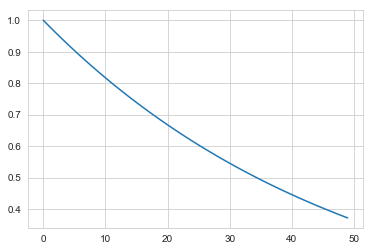

In [161]:
plt.plot(epochs, learning_rate)

In [199]:
power_t = 0
eta_0 = 0.1